In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [81]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

In [3]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [4]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [63]:
from models.CRNN import CRNN_model
from fbprophet import Prophet

# 1. Data

In [6]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-11-22 10:14:00,136 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-11-22 10:14:00,139 - EPM - INFO - [STEP 1] LOAD DATA
2019-11-22 10:14:00,139 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [7]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

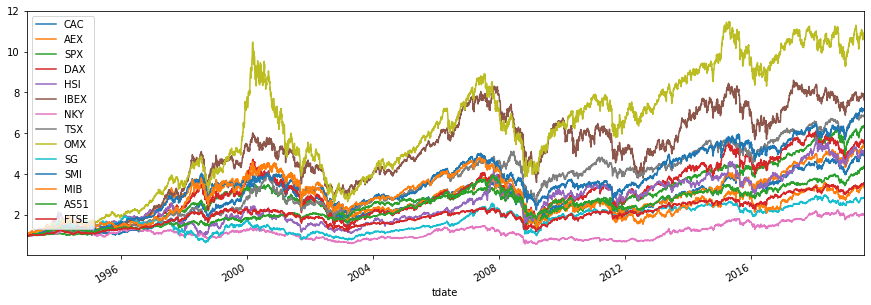

In [8]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

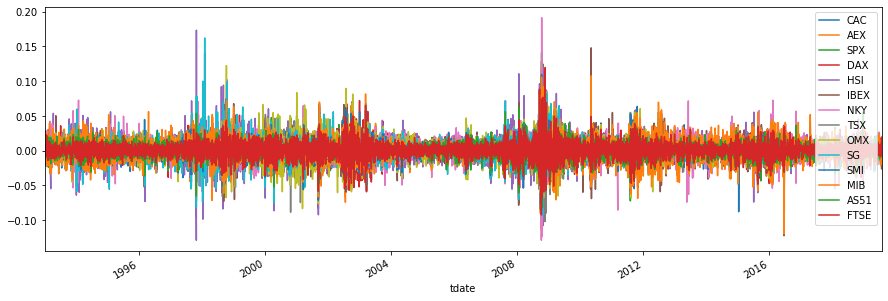

In [9]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

In [10]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 252]

In [11]:
from EEM import EEM

In [12]:
eem = EEM(strategy_name="EEM", asset_type="EQUITY")
eem.load_index_and_return(from_db=False, save_file=True)
eem.load_strategy_data(table='datastream', origin='ERR')
eem.set_rebalance_period(freq='month')
eem.calculate_signal(minobs1=12, nopos=0.4, CS=0.35, longlen=12, shortlen=6, lag=0)
eem.set_portfolio_parameter(cs_strategy_type='notional')
eem.make_portfolio()

2019-11-22 10:14:01,765 - EEM - INFO - [STEP 0] START LOGGING EEM
2019-11-22 10:14:01,766 - EEM - INFO - [STEP 1] LOAD DATA
2019-11-22 10:14:01,767 - EEM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-11-22 10:14:02,537 - EEM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-22 10:14:02,538 - EEM - INFO - [STEP 3] CACULATE SIGNAL
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\EEM.py:100: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\EEM.py:101: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-do

In [13]:
start_date = '2011-01-01'
end_date = '2018-05-09'

# get r results
eem_comp_df = pd.read_csv('../check/past/eem.csv', header=0, index_col=0, parse_dates=True)
eem_lag_comp_df = pd.read_csv('../check/past/eem_lag.csv', header=0, index_col=0, parse_dates=True)

In [14]:
tester = Tester(eem)
tester.set_period(start=start_date, end=end_date)
tester.run()

2019-11-22 10:14:28,916 - EEM - INFO - [STEP 6] START BACKTEST
2019-11-22 10:14:28,916 - EEM - INFO - [STEP 6 - 1] BACKTEST EEM TIME SERIES
2019-11-22 10:14:29,448 - EEM - INFO - [STEP 6 - 2] BACKTEST EEM CROSS SECTIONAL


In [15]:
to_plot = (1.+ eem_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = eem.TS_result
to_plot['CS_python'] = eem.CS_result
to_plot.iplot()

# 1. FEATURE

In [16]:
pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
RVrank = eem.RV.expanding().apply(pctrank, raw=True)

In [17]:
eem.RV.iplot()

In [89]:
epoch = 30
batch_size = 32

In [90]:
RV = RV.loc['1994':]

In [98]:
X = []
y = []

for i in range(RV.shape[0]):
    if i < 19:
        continue
    
    X.append(RV.iloc[i-19:i+1].values)
    y.append(RV.iloc[i].values)

In [99]:
train_size = RV.loc[:'2007'].shape[0]
val_size =  RV.loc[:'2010'].shape[0]
test_size = RV.loc[:]

train_X = np.array(X[:train_size]).reshape(-1, 20, RV.shape[1])
train_y = np.array(y[:train_size]).reshape(-1, RV.shape[1])

val_X = np.array(X[train_size:val_size]).reshape(-1, 20, RV.shape[1])
val_y = np.array(y[train_size:val_size]).reshape(-1, RV.shape[1])

test_X = np.array(X[val_size:]).reshape(-1, 20, RV.shape[1])
test_y = np.array(y[val_size:]).reshape(-1, RV.shape[1])

In [101]:
train_X.shape, train_y.shape
val_X.shape, val_y.shape
test_X.shape, test_y.shape

((2216, 20, 14), (2216, 14))

In [104]:
model1 = Sequential()
model1.add(LSTM(32, activation='relu', input_shape=(20, RV.shape[1], )))
model1.add(Dropout(0.5))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(14, activation='sigmoid'))
model1.compile(optimizer=optimizers.Adam(lr=0.01), loss='mse')
early_stopping = EarlyStopping(patience=10)

In [105]:
hist = model1.fit(train_X, train_y,
                  validation_data=(val_X, val_y),
                  batch_size=batch_size,
                  epochs=epoch,
                  shuffle=True, callbacks=[early_stopping])

Train on 3651 samples, validate on 781 samples
Epoch 1/30
3651/3651 [==============================] - 2s 420us/sample - loss: 26913.5725 - val_loss: 41389.8027
Epoch 2/30
3651/3651 [==============================] - 1s 208us/sample - loss: 26905.0334 - val_loss: 41392.2018
Epoch 3/30
3651/3651 [==============================] - 1s 203us/sample - loss: 26893.9700 - val_loss: 41352.6443
Epoch 4/30
3651/3651 [==============================] - 1s 203us/sample - loss: 26898.9319 - val_loss: 41441.6477
Epoch 5/30
3651/3651 [==============================] - 1s 212us/sample - loss: 26915.6961 - val_loss: 41443.1727
Epoch 6/30
3651/3651 [==============================] - 1s 210us/sample - loss: 26920.1102 - val_loss: 41465.0283
Epoch 7/30
3651/3651 [==============================] - 1s 203us/sample - loss: 26912.6331 - val_loss: 41462.8189
Epoch 8/30
3651/3651 [==============================] - 1s 213us/sample - loss: 26902.0444 - val_loss: 41385.4917
Epoch 9/30
3651/3651 [===================

In [33]:
df_index_sub = df_index.loc['1994':]
CSRV = CSRV.reindex(df_index.index)
long = CSRV.shape[1] / 10 * 7
short = CSRV.shape[1] / 10 * 3

df_pred_rank = CSRV.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [34]:
strategy.set_rebalance_period(freq='month')
tester = Tester(strategy)
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-11-22 10:29:07,507 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-11-22 10:29:07,508 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-11-22 10:29:07,508 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-11-22 10:29:07,509 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-11-22 10:29:21,518 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-11-22 10:29:21,518 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-11-22 10:29:23,938 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-11-22 10:29:23,944 - EPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-11-22 10:29:25,473 - EPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-11-22 10:29:25,476 - EPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-11-22 10:29:25,477 - EPM - INFO - [STEP 5 - 3 - 1] NO TARGET VOL CONTROL to CS POSITION
2019-11-22 10:29:25,477 - EPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-11-22 10:29:29,377 - EPM - INFO - 

### TEST

In [38]:
tester1 = Tester(strategy)
tester1.set_period(start=start_date, end=end_date)
tester1.run()

2019-11-22 10:29:54,586 - EPM - INFO - [STEP 6] START BACKTEST
2019-11-22 10:29:54,587 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-11-22 10:29:55,280 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL


In [39]:
to_plot['CS_ML'] = tester1.strategy.CS_result

# CASE 2. 70% 강조

- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [ ]:
df_index_y_binary1 = df_index_rank > df_index_rank.shape[1] / 4 * 3
df_index_y_binary1 = df_index_y_binary1.astype(np.float32)
df_y = df_index_y_binary1.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [ ]:
df_join2 = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2007-12-31')]
df_val = df_join2.loc[(df_join2['tdate'] >= pd.to_datetime('2008-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join2.loc[df_join2['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [ ]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

In [ ]:
test_pred = model.predict(df_test_x.values)

In [ ]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

df_pred2 = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [ ]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3
df_pred_rank2 = df_pred2.rank(axis=1)
df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [ ]:
strategy2 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=False, save_file=False)
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2
strategy2.set_rebalance_period(freq='month') 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

### TEST

In [ ]:
tester2 = Tester(strategy2)
tester2.set_period(start=start_date, end=end_date)
tester2.run()

In [ ]:
to_plot['CS_ML_UPPER'] = tester2.strategy.CS_result

In [ ]:
to_plot.iplot()

In [ ]:
result = pd.concat([eem.CS_summary,
                    eem.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary], axis=1)

In [ ]:
result

In [ ]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER']

# CASE 3. Case1을 Rolling으로 실행

In [ ]:
val_rolling_one_year = ['2007-12-31',
                    '2008-12-31',
                    '2009-12-31',
                    '2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31']

In [ ]:
test_rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [ ]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [ ]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

In [ ]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

In [ ]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [ ]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [ ]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)
strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

In [ ]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='month') 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

In [ ]:
tester3 = Tester(strategy3)
tester3.set_period(start=start_date, end=end_date)
tester3.run()

In [ ]:
to_plot['CS_ML_ROLLING'] = tester3.strategy.CS_result

In [ ]:
to_plot.iplot()

In [ ]:
result = pd.concat([eem.CS_summary,
                    eem.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary], axis=1)

In [ ]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING']

In [ ]:
result

# CASE 4. CASE 2를 ROLLING으로 실행

In [ ]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [ ]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join2.loc[df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join2.loc[(df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

In [ ]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [ ]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [ ]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)
strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

In [ ]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month') 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

In [ ]:
tester4 = Tester(strategy4)
tester4.set_period(start=start_date, end=end_date)
tester4.run()

In [ ]:
to_plot['CS_ML_UPPER_ROLLING'] = tester4.strategy.CS_result

In [ ]:
to_plot.iplot()

In [ ]:
result = pd.concat([eem.CS_summary,
                    eem.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary,
                    strategy4.CS_summary], axis=1)

In [ ]:
result

In [ ]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING', 'CS_ML_UPPER_ROLING']

In [ ]:
result